In [1]:
# Standard imports
import numpy as np
import yaml
import toml
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 20]

# bolo-calc import
from bolo import Top

In [2]:
yaml_file = 'SAT_pole_20210401.yaml'
dd = yaml.safe_load(open(yaml_file))
version_date = str(dd['version']['date'])
version_telescope = str(dd['version']['name'])
del dd['version']

ch_names = list(dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'].keys())

#Make dictionary of nominal PSATs. Enter values in pW. 
psat ={}
psat['SAT_pole_20210401'] = {'LF_1': 1.40, 'LF_2': 6.13, 'MF1_1': 7.40, 'MF1_2': 12.25, 'MF2_1': 7.65, 'MF2_2': 13.30, 'UHF_1': 29.88, 'UHF_2': 39.03}
psat['SPLAT_20210401'] = {'ULF': 0.42, 'LF_1': 0.69, 'LF_2': 4.32, 'MF_1': 4.65, 'MF_2': 11.49, 'UHF_1': 29.31, 'UHF_2': 40.02}
psat['CHLAT_20210401'] = {'LF_1': 0.72, 'LF_2': 3.84, 'MF_1': 4.47, 'MF_2': 13.95, 'UHF_1': 41.52, 'UHF_2': 60.78}

#convert to Watts
for channel in ch_names:    
    psat[yaml_file.partition('.')[0]][channel] *= 1e-12

#set psat factor to None & delete psat entry from channel default
dd['instrument']['channel_default']['psat_factor'] = None
del dd['instrument']['channel_default']['psat']

#assign SI psat values at the channel level
for channel in ch_names: 
    dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'][channel]['psat'] = psat[yaml_file.partition('.')[0]][channel]

# location of atmosphere file
dd['sim_config']['config_dir'] = '../../bolo-calc/config'

in_param = 'elevation'
base_value = dd['instrument'][in_param]
param_vec = np.arange(30,70,1)
# in_param possible values:
#  'band_response', 'num_wafer_per_optics_tube', 'num_optics_tube', 
#  'waist_factor', 'psat', 'psat_factor', 'carrier_index', 'Tc', 'Tc_fraction', 
#  'G', 'Flink', 'Yield', 'response_factor', 'bolo_resistance', 'read_frac'

out_param = 'NET' #
# out_param possible values:
#  'effic', 'opt_power','tel_rj_temp','sky_rj_temp','NEP_bolo',
#  'NEP_read','NEP_ph','NEP','NET','NET_corr','corr_fact','NET_arr'

In [3]:
outputs = {}
outputs[out_param]={}
for chan in ch_names:
    outputs[out_param][chan]=np.array([])

for param_value in param_vec:
    dd['instrument'][in_param] = param_value
    top = Top(**dd)
    top.run()
    tabs = top.instrument.tables
    for chan in ch_names:
        outputs[out_param][chan] = np.append(outputs[out_param][chan], tabs['cam_1_%s_sims' % chan][out_param].quantity[0])

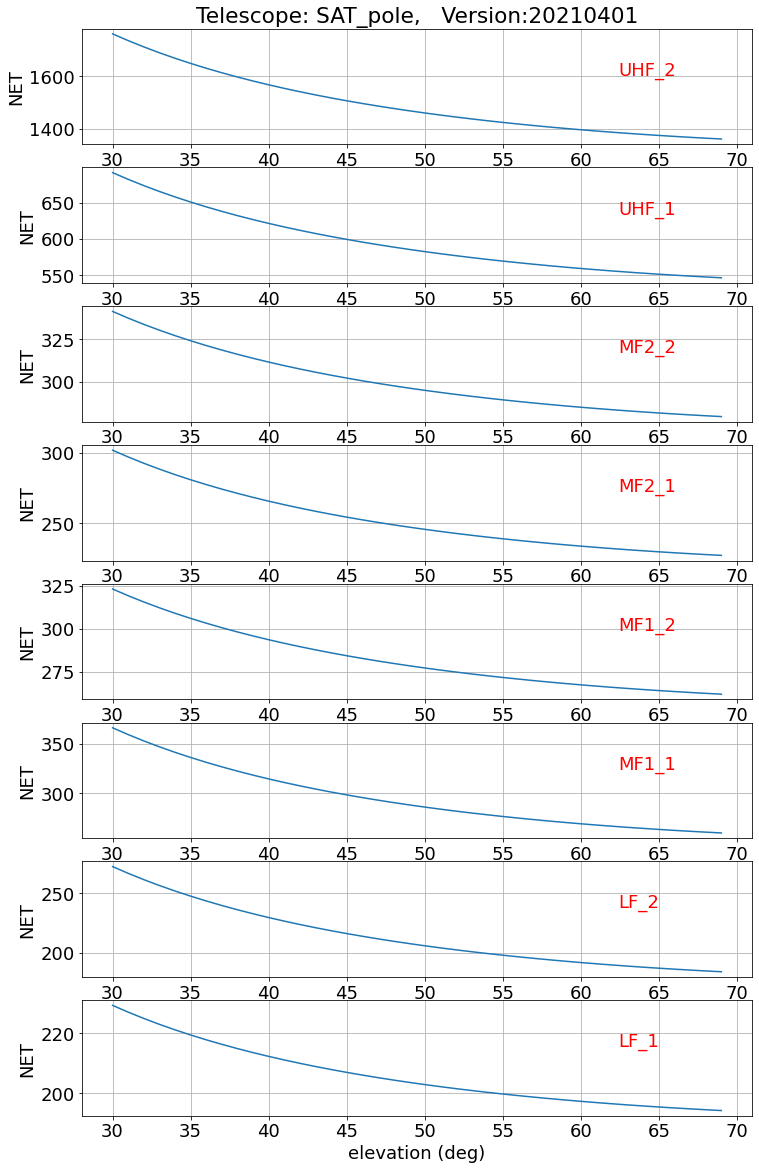

In [4]:
plt.clf()
n_chan = len(ch_names)
ii = n_chan

for chan in ch_names:
    plt.subplot(n_chan,1,ii)
    plt.plot(param_vec,outputs[out_param][chan]) 
    plt.ylabel(out_param)
    if ii == n_chan:
        plt.xlabel(in_param + ' (deg)')
    xmin, xmax, ymin, ymax = plt.axis()
    #plt.plot([base_value,base_value],[ymin,ymax],'r')
    xloc = xmin + 0.8*(xmax-xmin)
    yloc = ymin + 0.6*(ymax-ymin)
    plt.text(xloc,yloc,chan,color='r')
    plt.grid()
    ii = ii-1
titlestring = 'Telescope: '+version_telescope+',   Version:'+version_date
plt.title(titlestring)
plt.savefig('plots/' + yaml_file.partition('.')[0] + '_' + out_param + '_v_' + in_param + '.png', dpi=300)

In [5]:
toml_output ={}
toml_output['runtime'] = datetime.today().strftime('%Y/%m/%d %H:%M:%S')
toml_output['input_id'] = version_date
toml_output['variation'] = out_param + '_v_' + in_param
toml_output['telescope'] = version_telescope
toml_output[in_param] = param_vec
for key in ch_names:
    toml_output[key] = np.array(outputs[out_param][key])
    
output_file_name = yaml_file.partition('.')[0] + '_' + out_param + '_v_' + in_param + '.toml'
with open('outputs/' + output_file_name, "w") as toml_file:
    toml.dump(toml_output, toml_file)

In [6]:
dd['instrument']['channel_default']['psat_factor']

In [7]:
psat *.1

TypeError: unsupported operand type(s) for *: 'dict' and 'float'